Соревнование на kaggle по классификации https://www.kaggle.com/competitions/journey-springfield

In [2]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
import PIL
print(PIL.__version__)

9.5.0


In [4]:
!ls train

ls: cannot access 'train': No such file or directory


In [5]:
!nvidia-smi
import torch
torch.cuda.is_available()

Mon Nov 20 10:51:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [60]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from torchvision import models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [7]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

Добавим аугументацию, поворот и отражение по горизонтали

In [8]:
class SimpsonsDataset(Dataset):

    def __init__(self, files, mode):
        super().__init__()
        # dataset for download
        self.files = sorted(files)
        # dataset mode by model mode
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index, RESCALE_SIZE=256):
        # transformation by mode and normalization
        transformers = {
            'train':
            transforms.Compose([
                      transforms.RandomResizedCrop(size=RESCALE_SIZE),
                      transforms.RandomPerspective(distortion_scale=0.1),
                      transforms.RandomRotation(degrees=15),
                      transforms.ColorJitter(),
                      transforms.RandomHorizontalFlip(),
                      transforms.CenterCrop(size=RESCALE_SIZE),  # Imagenet standards
                      transforms.ToTensor(),
                      transforms.Normalize([0.485, 0.456, 0.406],
                                           [0.229, 0.224, 0.225])
            ]),
            'val':
            transforms.Compose([
                      transforms.Resize(size=RESCALE_SIZE+20),
                      transforms.CenterCrop(size=RESCALE_SIZE),
                      transforms.ToTensor(),
                      transforms.Normalize([0.485, 0.456, 0.406],
                                           [0.229, 0.224, 0.225])
            ]),
            'test':
            transforms.Compose([
                      transforms.Resize(size=RESCALE_SIZE+20),
                      transforms.CenterCrop(size=RESCALE_SIZE),
                      transforms.ToTensor(),
                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        }

        x = self.load_sample(self.files[index])

        # mode -> transformer
        if self.mode == 'train':
            x = transformers['train'](x)
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

        elif self.mode == 'val':
            x = transformers['val'](x)
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

        else:
            x = transformers['test'](x)
            return x

In [9]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [10]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('/kaggle/input/springfield/train')
TEST_DIR = Path('/kaggle/input/springfield/testset')

In [11]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [12]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [13]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Давайте посмотрим на наших героев внутри датасета.

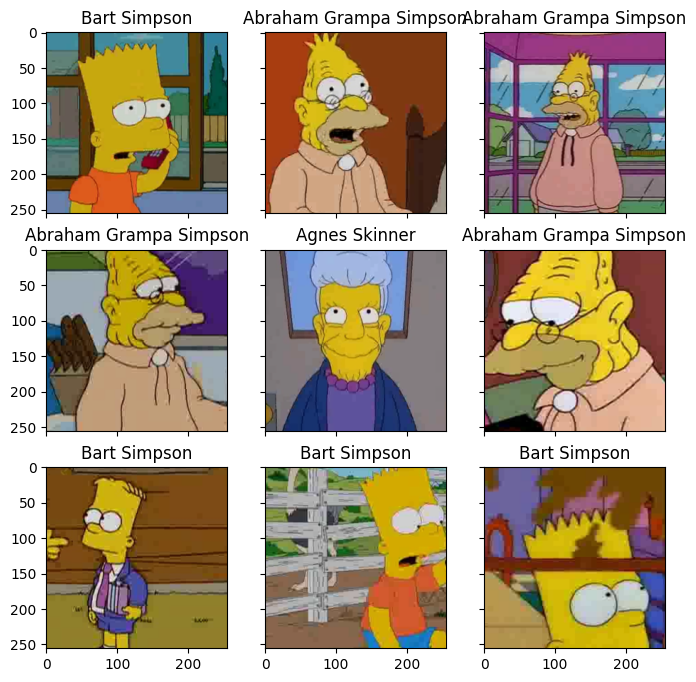

In [14]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [15]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [16]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

По рекомендации в ноутбуке с домашник заданием, заменим оптимайзер на AdamW

In [55]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters(), lr=3e-4)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [56]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

Запустим обучение сети.

In [57]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

После изучения статьи на habr (https://habr.com/ru/articles/666314/), были сделаны попытки обучить EfficientNet и ResNet, но они не дали необходимой точности с дефолтными параметрами. Лучший результат показала MobNet, а так же был подобран lr = 3e-4

In [61]:
model = models.mobilenet_v3_large(pretrained=True)
model

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 80.5MB/s]


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [65]:
num_features = 960
n_classes = len(np.unique(train_val_labels))
model.classifier = nn.Sequential(
                                  nn.Linear(num_features, 1280, bias=True),
                                  nn.Hardswish(),
                                  nn.Dropout(p=0.2, inplace=True),
                                  nn.Linear(1280, n_classes, bias=True) 
)

model.to(DEVICE)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [76]:
history = train(train_dataset, val_dataset, model, epochs=15, batch_size=256,
                        )

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

loss 0.383416071381339


epoch:   7%|▋         | 1/15 [03:31<49:27, 211.96s/it]


Epoch 001 train_loss: 0.3834     val_loss 0.1347 train_acc 0.8973 val_acc 0.9712
loss 0.3614649370514866


epoch:  13%|█▎        | 2/15 [06:43<43:22, 200.16s/it]


Epoch 002 train_loss: 0.3615     val_loss 0.1414 train_acc 0.9022 val_acc 0.9702
loss 0.3453517780386572


epoch:  20%|██        | 3/15 [09:56<39:22, 196.89s/it]


Epoch 003 train_loss: 0.3454     val_loss 0.1285 train_acc 0.9044 val_acc 0.9723
loss 0.34187258768232776


epoch:  27%|██▋       | 4/15 [13:06<35:35, 194.11s/it]


Epoch 004 train_loss: 0.3419     val_loss 0.1260 train_acc 0.9071 val_acc 0.9702
loss 0.3130218169259618


epoch:  33%|███▎      | 5/15 [16:16<32:05, 192.55s/it]


Epoch 005 train_loss: 0.3130     val_loss 0.1168 train_acc 0.9154 val_acc 0.9731
loss 0.3121047955697126


epoch:  40%|████      | 6/15 [19:27<28:49, 192.13s/it]


Epoch 006 train_loss: 0.3121     val_loss 0.1286 train_acc 0.9145 val_acc 0.9725
loss 0.30463416282405775


epoch:  47%|████▋     | 7/15 [22:36<25:27, 190.96s/it]


Epoch 007 train_loss: 0.3046     val_loss 0.1253 train_acc 0.9167 val_acc 0.9708
loss 0.3035521839808048


epoch:  53%|█████▎    | 8/15 [25:44<22:11, 190.22s/it]


Epoch 008 train_loss: 0.3036     val_loss 0.1258 train_acc 0.9173 val_acc 0.9700
loss 0.29265817161145213


epoch:  60%|██████    | 9/15 [28:51<18:54, 189.14s/it]


Epoch 009 train_loss: 0.2927     val_loss 0.1243 train_acc 0.9189 val_acc 0.9731
loss 0.2805901984058601


epoch:  67%|██████▋   | 10/15 [32:03<15:50, 190.03s/it]


Epoch 010 train_loss: 0.2806     val_loss 0.1086 train_acc 0.9232 val_acc 0.9778
loss 0.27808336974617875


epoch:  73%|███████▎  | 11/15 [35:12<12:38, 189.55s/it]


Epoch 011 train_loss: 0.2781     val_loss 0.1189 train_acc 0.9232 val_acc 0.9752
loss 0.2802734868582574


epoch:  80%|████████  | 12/15 [38:19<09:26, 188.86s/it]


Epoch 012 train_loss: 0.2803     val_loss 0.1134 train_acc 0.9226 val_acc 0.9788
loss 0.28345288030166776


epoch:  87%|████████▋ | 13/15 [41:27<06:16, 188.50s/it]


Epoch 013 train_loss: 0.2835     val_loss 0.1258 train_acc 0.9217 val_acc 0.9746
loss 0.26728110172671266


epoch:  93%|█████████▎| 14/15 [44:38<03:09, 189.23s/it]


Epoch 014 train_loss: 0.2673     val_loss 0.1183 train_acc 0.9255 val_acc 0.9733
loss 0.26710993935973926


epoch: 100%|██████████| 15/15 [47:47<00:00, 191.18s/it]


Epoch 015 train_loss: 0.2671     val_loss 0.1214 train_acc 0.9273 val_acc 0.9750


Построим кривые обучения

In [77]:
loss, acc, val_loss, val_acc = zip(*history)

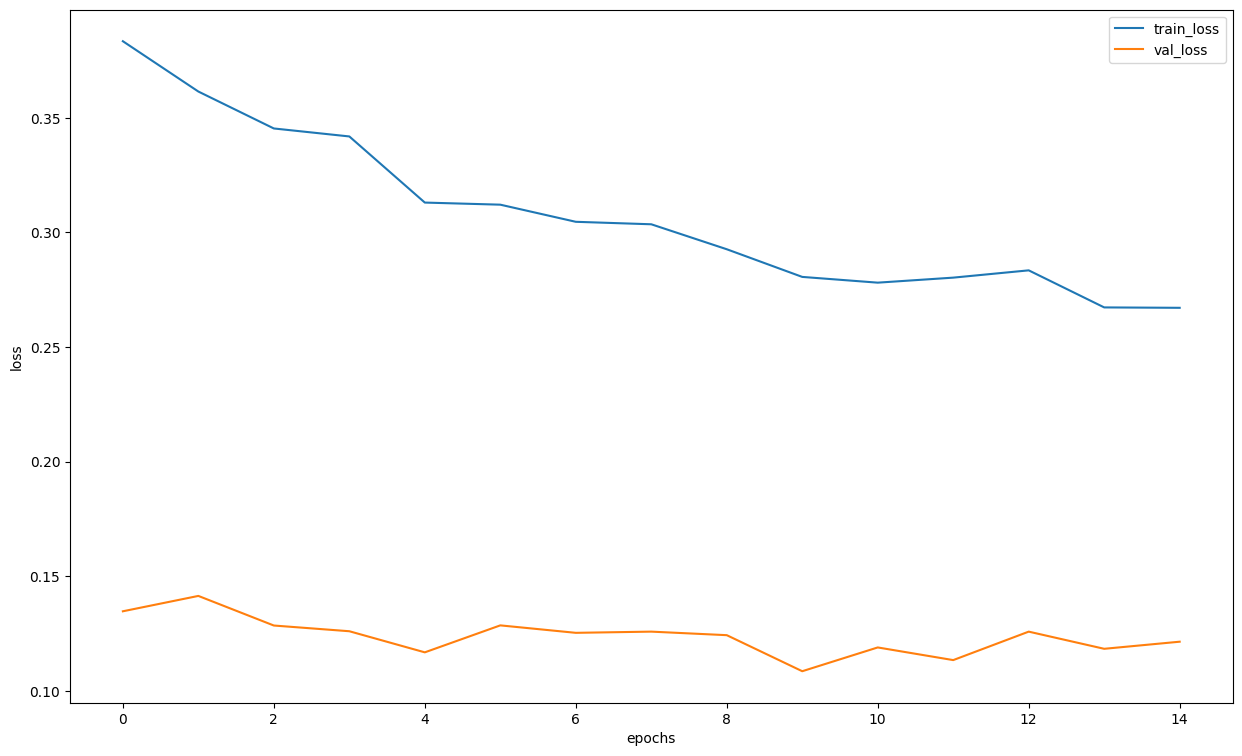

In [78]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [79]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [80]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [81]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

In [82]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [83]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Вычислим целевую метрику f1-score на валидационной выборке.

In [84]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)


F1-оценка: 1.0


Выполним визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах

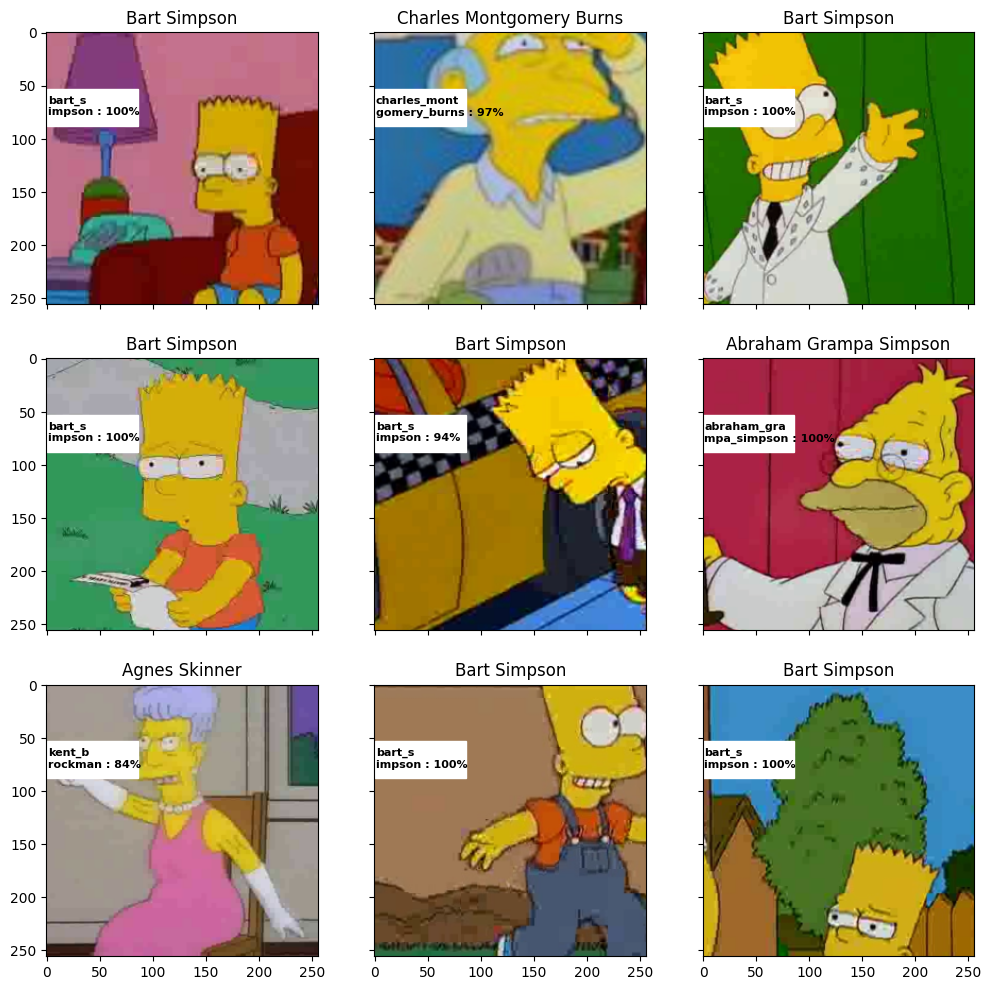

In [85]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

### Submit на Kaggle

In [86]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [87]:
! ls

eff_net_bragin.csv  label_encoder.pkl


In [88]:
import pandas as pd
my_submit = pd.read_csv("/kaggle/input/springfield/sample_submission.csv")
my_submit = pd.DataFrame({'id': test_filenames, 'Expected': preds})
my_submit.head()

,id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [89]:
my_submit.to_csv('mobnet_l_bragin.csv', index=False)

Название команды: Vasya_Bragin_458065623

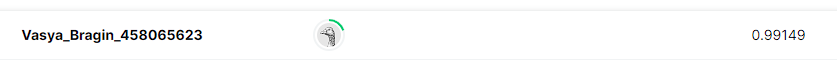